# Convex Optimization Exercise 4

By Gholamreza Dar

Dr. Amirmazlaghani

Summer 2022

## Imports

In [25]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns; sns.set(); sns.set_style('dark')

from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from sklearn.linear_model import LassoCV


from joblib import Parallel, delayed
import multiprocessing

from tqdm import trange

## Functions

In [26]:
def calculate_nu_t(nu_t, ro, X_t, z_t):
    return nu_t + ro*(X_t - z_t)


In [27]:
def calculte_z_t(z_t, X_t, nu_t, ro, lambd):
    e_grad = X_t + nu_t*1.0/ro
    z_t_new = np.zeros_like(z_t)
    l = -(1.0*lambd/ro)*(z_t<0)
    g = (1.0*lambd/ro)*(z_t>0)
    z_t_new = e_grad - l - g
    return z_t_new

In [28]:
def calculte_x_t(X_train, y_train, ro, z_t, nu_t, dim):
    t1 = np.linalg.inv(X_train.T.dot(X_train) + ro * np.identity(dim))
    t2 = X_train.T.dot(y_train) + ro*z_t -  nu_t
    return t1.dot(t2)

In [29]:
def calculate_value(X_train, X_t, y_train, lambd):
    return 0.5*np.linalg.norm(X_train.dot(X_t) - y_train, ord='fro')**2 + lambd*np.linalg.norm(X_t, ord=1)


In [30]:
def calculate_paralell(i,X_train,y_train,nu_t,ro,z_t,X_t):
    ai = X_train[i].reshape(-1,1).T
    bi = y_train[i].reshape(-1,1)
    bi = bi.item()
    nui = nu_t[i].reshape(-1,1)
    term1 = 1/(ai.dot(ai.T) + ro)
    term2 = ai.T*bi + ro*z_t - nui
    term1 = term1.item()
    x = term1*term2
    x = x.T
    X_t[i] = x

In [31]:
def debug_admm(X_train, y_train, X_test, y_test, X_t, iterations=100, lambd=0.01, iteration=0):
    val = calculate_value(X_train, X_t, y_train, lambd)
    train_err = mean_squared_error(X_train.dot(X_t), y_train)
    test_err = mean_squared_error(X_test.dot(X_t), y_test)
    if iteration%10==0:
        print(f"Iteration {iteration}/{iterations} | Value: {round(val, 4)} | train_loss: {train_err.round(8)} | test_loss: {test_err.round(8)}")
    return (train_err, test_err)

In [32]:
def ADMM(X_train, y_train, X_test, y_test, dim=8, iterations=100, lambd=0.01, debug=True):
    # Start with random X and zero z and nu
    ro = 1
    X_t = np.random.randn(dim, 1)
    z_t = np.zeros((dim,1))
    nu_t = np.zeros((dim,1))

    if debug:
        print("Initial Value:", calculate_value(X_train, X_t, y_train, lambd))

    # Loss history
    history = np.zeros((iterations, 2))

    # Update x_t, z_t, nu_t for a many iterations
    for i in trange(iterations):
        X_t = calculte_x_t(X_train, y_train, ro, z_t, nu_t, dim)
        z_t = calculte_z_t(z_t, X_t, nu_t, ro, lambd)
        nu_t = calculate_nu_t(nu_t,ro,X_t,z_t)
        
        if debug:
            train_loss, test_loss = debug_admm(X_train, y_train, X_test, y_test, X_t, iterations=100, lambd=0.01, iteration=i)
            history[i, 0] = train_loss
            history[i, 1] = test_loss
            
    return history


In [33]:
def update_nu_t_paralell(nu_t,X_t,z_t,ro):
    for i in range(nu_t.shape[0]):
        nu_t[i] = (nu_t[i].reshape(-1,1) + ro*(X_t[i].reshape(-1,1) - z_t)).T
    return nu_t

In [34]:
def Parallel_ADMM(X_train, y_train, X_test, y_test, dim=8, iterations=100, lambd=0.01, debug=True):
    # Start with random X and zero z and nu
    ro = 1
    n = X_train.shape[0]
    X_t = np.tile(np.random.randn(dim, 1).T, (n,1))
    z_t = np.zeros((dim,1))
    nu_t = np.tile(np.zeros((dim,1)).T, (n,1))

    X = np.mean(X_t, axis=0).reshape(-1,1)

    # Loss history
    history = np.zeros((iterations, 2))

    for iteration in range(iterations):
        Parallel(n_jobs=multiprocessing.cpu_count() , require='sharedmem')(delayed(calculate_paralell)(i,X_train,y_train,nu_t,ro,z_t,X_t) for i in range(n))

        X = np.mean(X_t, axis=0).reshape(-1,1)
        nu = np.mean(nu_t, axis=0).reshape(-1,1)
        z_t = calculte_z_t(z_t, X, nu, ro, lambd)
        nu_t = update_nu_t_paralell(nu_t,X_t,z_t,ro)
    
        if debug:
            train_loss, test_loss = debug_admm(X_train, y_train, X_test, y_test, X, iterations=100, lambd=0.01, iteration=iteration)
            history[iteration, 0] = train_loss
            history[iteration, 1] = test_loss
    
    return history

In [35]:
def LassoCV_Regresion(X_train, y_train, X_test, y_test):
    model = LassoCV(cv=5, random_state=0).fit(X_train, y_train)

    y_predict_train = model.predict(X_train)
    y_predict_test = model.predict(X_test)
    
    print(f"RMSE Train: {mean_squared_error(y_predict_train, y_train).round(8)}")
    print(f"RMSE Test: {mean_squared_error(y_predict_test, y_test).round(8)}")

## Load Dataset

### Read the csv file

In [36]:
dataset = pd.read_csv("ENB2012_data.csv")
dataset = dataset.sample(frac=1).reset_index(drop=True).to_numpy()

### Normalize the dataset

In [37]:
dataset = preprocessing.normalize(dataset)

### Train Test Split

In [38]:
threshold = int(0.8 * len(dataset))
train_data = dataset[:threshold]
test_data = dataset[threshold:]
X_train, y1_train, y2_train = train_data[:,:8], train_data[:,8].reshape((-1,1)), train_data[:,9].reshape((-1,1))
X_test, y1_test, y2_test = test_data[:,:8], test_data[:,8].reshape((-1,1)), test_data[:,9].reshape((-1,1))

## ADMM ; y_1 

In [39]:
history1 = ADMM(
    X_train, y1_train,
    X_test, y1_test,
    dim=8,
    iterations=100,
    lambd=0.01)

Initial Value: 4.760404419803465


100%|██████████| 100/100 [00:00<00:00, 1052.63it/s]

Iteration 0/100 | Value: 0.0233 | train_loss: 6.885e-05 | test_loss: 7.477e-05
Iteration 10/100 | Value: 0.0218 | train_loss: 6e-05 | test_loss: 6.879e-05
Iteration 20/100 | Value: 0.0216 | train_loss: 6.044e-05 | test_loss: 6.923e-05
Iteration 30/100 | Value: 0.0217 | train_loss: 6.027e-05 | test_loss: 6.902e-05
Iteration 40/100 | Value: 0.0216 | train_loss: 6.044e-05 | test_loss: 6.921e-05
Iteration 50/100 | Value: 0.0217 | train_loss: 6.038e-05 | test_loss: 6.903e-05
Iteration 60/100 | Value: 0.0217 | train_loss: 6.02e-05 | test_loss: 6.883e-05
Iteration 70/100 | Value: 0.0218 | train_loss: 6.065e-05 | test_loss: 6.951e-05
Iteration 80/100 | Value: 0.0218 | train_loss: 6.067e-05 | test_loss: 6.952e-05
Iteration 90/100 | Value: 0.0217 | train_loss: 6.056e-05 | test_loss: 6.939e-05


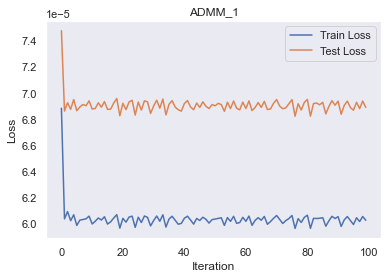

In [40]:
plt.figure()

plt.plot(np.arange(history1.shape[0]), history1[:, 0])
plt.plot(np.arange(history1.shape[0]), history1[:, 1])

plt.title("ADMM_1")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend(["Train Loss", "Test Loss"])

plt.show()


## ADMM ; y_2

In [41]:
history2 = ADMM(
    X_train, y2_train,
    X_test, y2_test,
    dim=8,
    iterations=100,
    lambd=0.01)

Initial Value: 44.602752428219524


100%|██████████| 100/100 [00:00<00:00, 990.08it/s]

Iteration 0/100 | Value: 0.0237 | train_loss: 7.046e-05 | test_loss: 7.24e-05
Iteration 10/100 | Value: 0.0223 | train_loss: 6.27e-05 | test_loss: 6.767e-05
Iteration 20/100 | Value: 0.0222 | train_loss: 6.259e-05 | test_loss: 6.757e-05
Iteration 30/100 | Value: 0.0222 | train_loss: 6.272e-05 | test_loss: 6.783e-05
Iteration 40/100 | Value: 0.0222 | train_loss: 6.274e-05 | test_loss: 6.786e-05
Iteration 50/100 | Value: 0.0224 | train_loss: 6.301e-05 | test_loss: 6.818e-05
Iteration 60/100 | Value: 0.0224 | train_loss: 6.279e-05 | test_loss: 6.796e-05
Iteration 70/100 | Value: 0.0223 | train_loss: 6.259e-05 | test_loss: 6.753e-05
Iteration 80/100 | Value: 0.0221 | train_loss: 6.259e-05 | test_loss: 6.755e-05
Iteration 90/100 | Value: 0.0224 | train_loss: 6.21e-05 | test_loss: 6.708e-05


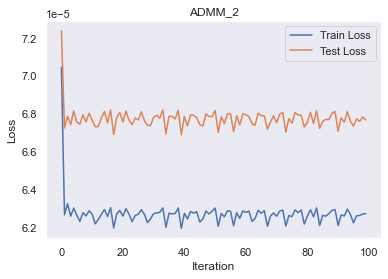

In [42]:
plt.figure()

plt.plot(np.arange(history2.shape[0]), history2[:, 0])
plt.plot(np.arange(history2.shape[0]), history2[:, 1])

plt.title("ADMM_2")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend(["Train Loss", "Test Loss"])

plt.show()


## Parallel ADMM ; y_1

In [43]:
history3 = Parallel_ADMM(
    X_train, y1_train,
    X_test, y1_test,
    dim=8,
    iterations=100,
    lambd=0.01)

Iteration 0/100 | Value: 0.1426 | train_loss: 0.00046373 | test_loss: 0.0005629
Iteration 10/100 | Value: 0.149 | train_loss: 0.00048309 | test_loss: 0.00058573
Iteration 20/100 | Value: 0.1489 | train_loss: 0.00048264 | test_loss: 0.00058519
Iteration 30/100 | Value: 0.1489 | train_loss: 0.00048264 | test_loss: 0.00058519
Iteration 40/100 | Value: 0.1489 | train_loss: 0.00048264 | test_loss: 0.00058519
Iteration 50/100 | Value: 0.1489 | train_loss: 0.00048264 | test_loss: 0.00058519
Iteration 60/100 | Value: 0.1489 | train_loss: 0.00048264 | test_loss: 0.00058519
Iteration 70/100 | Value: 0.1489 | train_loss: 0.00048264 | test_loss: 0.00058519
Iteration 80/100 | Value: 0.1489 | train_loss: 0.00048264 | test_loss: 0.00058519
Iteration 90/100 | Value: 0.1489 | train_loss: 0.00048264 | test_loss: 0.00058519


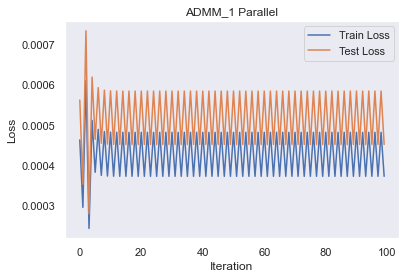

In [44]:
plt.figure()

plt.plot(np.arange(history3.shape[0]), history3[:, 0])
plt.plot(np.arange(history3.shape[0]), history3[:, 1])

plt.title("ADMM_1 Parallel")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend(["Train Loss", "Test Loss"])

plt.show()


## Parallel ADMM ; y_2

In [45]:
history4 = Parallel_ADMM(
    X_train, y2_train,
    X_test, y2_test,
    dim=8,
    iterations=100,
    lambd=0.01)

Iteration 0/100 | Value: 0.1537 | train_loss: 0.00049966 | test_loss: 0.00059219
Iteration 10/100 | Value: 0.1455 | train_loss: 0.00047141 | test_loss: 0.00055933
Iteration 20/100 | Value: 0.1453 | train_loss: 0.00047091 | test_loss: 0.00055875
Iteration 30/100 | Value: 0.1453 | train_loss: 0.00047091 | test_loss: 0.00055875
Iteration 40/100 | Value: 0.1453 | train_loss: 0.00047091 | test_loss: 0.00055875
Iteration 50/100 | Value: 0.1453 | train_loss: 0.00047091 | test_loss: 0.00055875
Iteration 60/100 | Value: 0.1453 | train_loss: 0.00047091 | test_loss: 0.00055875
Iteration 70/100 | Value: 0.1453 | train_loss: 0.00047091 | test_loss: 0.00055875
Iteration 80/100 | Value: 0.1453 | train_loss: 0.00047091 | test_loss: 0.00055875
Iteration 90/100 | Value: 0.1453 | train_loss: 0.00047091 | test_loss: 0.00055875


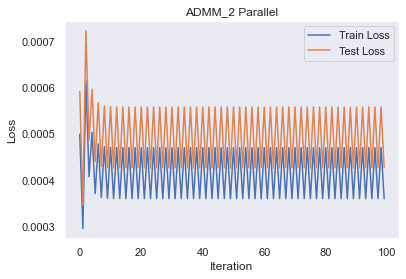

In [46]:
plt.figure()

plt.plot(np.arange(history4.shape[0]), history4[:, 0])
plt.plot(np.arange(history4.shape[0]), history4[:, 1])

plt.title("ADMM_2 Parallel")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend(["Train Loss", "Test Loss"])

plt.show()


## Lasso CV Regression ; y_1

In [47]:
LassoCV_Regresion(X_train, y1_train.ravel(), X_test, y1_test)

RMSE Train: 3.113e-05
RMSE Test: 3.44e-05


## Lasso CV Regression ; y_2

In [48]:
LassoCV_Regresion(X_train, y2_train.ravel(), X_test, y2_test)

RMSE Train: 2.786e-05
RMSE Test: 3.198e-05
